In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
!ls "/content/gdrive/MyDrive/dataset/train"

england  india	usa


In [40]:
from __future__ import print_function
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler


In [41]:
def load_image_data(paths, label_dict, img_rows=150, img_cols=25):
    """
    Loads images and labels from specified paths.

    Parameters:
        paths (list): List of paths where the images are located.
        label_dict (dict): Dictionary mapping folder names to class indices.
        img_rows (int): Target height of the images.
        img_cols (int): Target width of the images.

    Returns:
        tuple: Tuple containing:
            - x_data (numpy.ndarray): Array of processed images.
            - y_data (numpy.ndarray): Array of one-hot encoded labels.
    """
    x_data = []
    y_data = []

    for path in paths:
        for image_path in glob.glob(path):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (img_rows, img_cols))
                x_data.append(img_resized)
                # Extract the label from the folder structure
                label = image_path.split('/')[-2]  #Get label
                y_data.append(label_dict.get(label, -1))
            else:
                print(f"Failed to load image: {image_path}")

    x_data = np.array(x_data).reshape(-1, img_rows, img_cols, 1)
    x_data = x_data.astype('float32') / 255
    y_data = to_categorical(y_data, len(label_dict))

    return x_data, y_data


In [42]:
# Define paths and label dictionary
val_paths = [
    "/content/gdrive/MyDrive/dataset/val/england/*",
    "/content/gdrive/MyDrive/dataset/val/india/*",
    "/content/gdrive/MyDrive/dataset/val/usa/*"
]

train_paths = [
    "/content/gdrive/MyDrive/dataset/train/england/*",
    "/content/gdrive/MyDrive/dataset/train/india/*",
    "/content/gdrive/MyDrive/dataset/train/usa/*"
]

dico_labels = {
    'england': 0,
    'india': 1,
    'usa': 2
}

# Load validation data
x_val, y_val = load_image_data(val_paths, dico_labels)

# Load train data
x_train, y_train = load_image_data(train_paths, dico_labels)


In [43]:
# Count the number of samples per class
class_counts = np.sum(y_train, axis=0)
print("Number of samples per class:", class_counts)

Number of samples per class: [348. 581. 976.]


In [44]:
class_counts = np.sum(y_val, axis=0)
print("Number of samples per class:", class_counts)

Number of samples per class: [ 88. 146. 245.]


In [45]:
# Model definition
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Additional Conv2D layer for deeper feature extraction
        Conv2D(256, (3, 1), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_shape = (150, 25, 1)
num_classes = 3

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('./gdrive/MyDrive/cnn/accent_model.keras',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=3,
                                 min_lr=1e-6)

In [46]:
pip install scikit-learn

In [47]:
from sklearn.utils.class_weight import compute_class_weight


class_labels = np.array([0, 1, 2])
y_integers = np.argmax(y_train, axis=1)  # Convert one-hot encoded labels to integers

# Compute class weights
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_integers)
class_weight_dict = dict(enumerate(class_weights))


In [52]:
model.summary()
model = build_model(input_shape, num_classes)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 23, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 148, 23, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 74, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 9, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 72, 9, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 36, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 2, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 34, 2, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 17, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 1, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 15, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 15, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         491,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,053,643 (7.83 MB)

 Trainable params: 684,227 (2.61 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,368,456 (5.22 MB)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4372 - loss: 7.6684
Epoch 1: val_loss improved from inf to 9.78420, saving model to ./gdrive/MyDrive/cnn/accent_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.4373 - loss: 7.6665 - val_accuracy: 0.5115 - val_loss: 9.7842 - learning_rate: 0.0010
Epoch 2/100
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4959 - loss: 6.6382
Epoch 2: val_loss did not improve from 9.78420
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4959 - loss: 6.6353 - val_accuracy: 0.5115 - val_loss: 11.4950 - learning_rate: 0.0010
Epoch 3/100
110/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5226 - loss: 6.0321
Epoch 3: val_loss did not improve from 9.78420
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5223 - loss: 6.0132 - val_accuracy: 0.5115 - val_loss: 10.8147 - learning_rate: 0.0010
Epoch 4/100
111/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5583 - loss: 5.2133
Epoch 4: val_loss did not

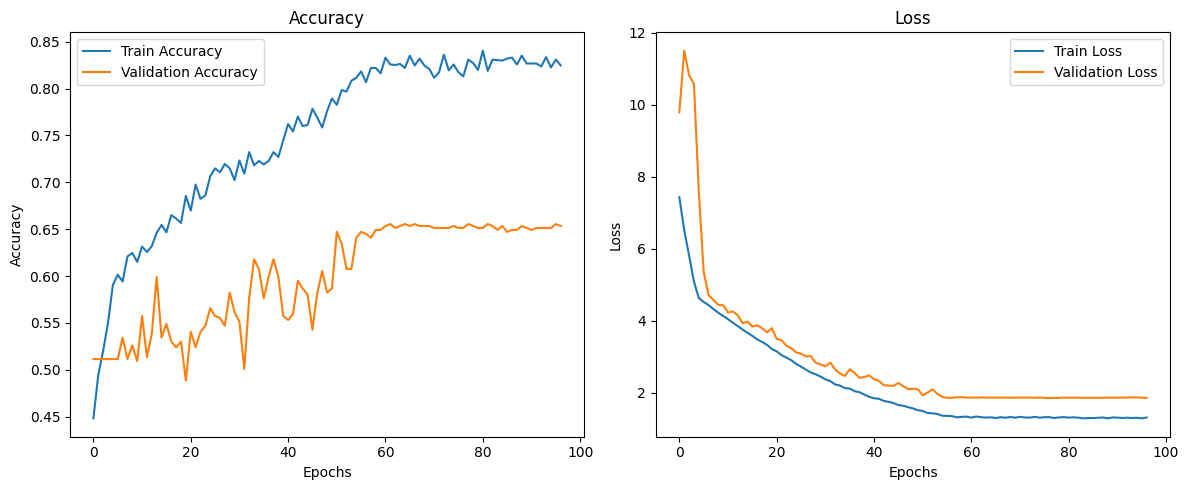

Validation loss: 1.8659719228744507
Validation accuracy: 0.6534446477890015
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


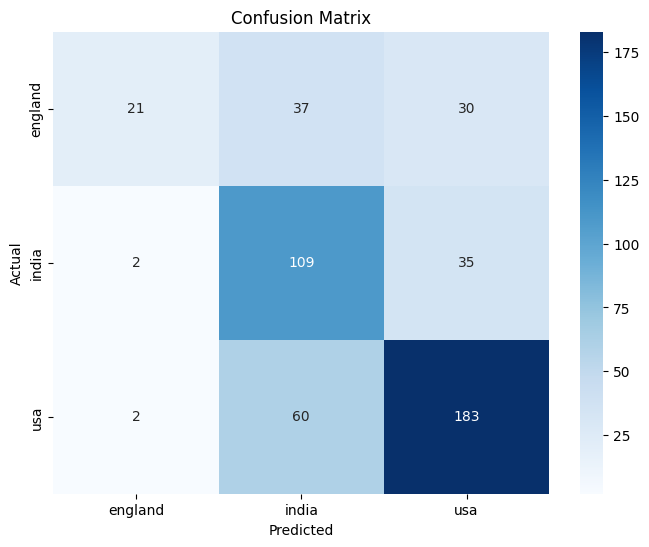

In [48]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[es, mc, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Final model evaluation
# -----------------------------
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# -----------------------------
# Confusion matrix
# -----------------------------

class_names = ['england', 'india', 'usa']

y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [51]:
# Precision, Recall, and F1 Score calculation
TP = np.diag(cm)  # True Positives are on the diagonal
FP = cm.sum(axis=0) - TP  # False Positives are the column sums minus the diagonal
FN = cm.sum(axis=1) - TP  # False Negatives are the row sums minus the diagonal

precision = np.sum(TP / (TP + FP)) / len(TP)  # Precision per class, then average
recall = np.sum(TP / (TP + FN)) / len(TP)  # Recall per class, then average
f1_score = 2 * (precision * recall) / (precision + recall)  # F1 Score

print(f"Average Precision: {precision:.4f}")
print(f"Average Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Average Precision: 0.7023
Average Recall: 0.5774
F1 Score: 0.6338


In [50]:
import numpy as np

# cm is a 3x3 confusion matrix: rows = true classes, cols = predicted classes

# True Positives: diagonal elements
TP = np.diag(cm)

# False Positives: column sum minus diagonal
FP = cm.sum(axis=0) - TP

# False Negatives: row sum minus diagonal
FN = cm.sum(axis=1) - TP

# ----- Per-class metrics -----
precision_per_class = TP / (TP + FP)
recall_per_class    = TP / (TP + FN)
f1_per_class        = 2 * precision_per_class * recall_per_class / (precision_per_class + recall_per_class)

# ----- Macro average (unweighted) -----
macro_precision = precision_per_class.mean()
macro_recall    = recall_per_class.mean()
macro_f1        = f1_per_class.mean()

# ----- Print results -----
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall:    {recall_per_class[i]:.4f}")
    print(f"  F1 Score:  {f1_per_class[i]:.4f}\n")

print("----- Macro Average -----")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall:    {macro_recall:.4f}")
print(f"F1 Score:  {macro_f1:.4f}")


Class 0:
  Precision: 0.8400
  Recall:    0.2386
  F1 Score:  0.3717

Class 1:
  Precision: 0.5291
  Recall:    0.7466
  F1 Score:  0.6193

Class 2:
  Precision: 0.7379
  Recall:    0.7469
  F1 Score:  0.7424

----- Macro Average -----
Precision: 0.7023
Recall:    0.5774
F1 Score:  0.5778
